# Transfer Learning with Tensorflow part1: Feature Extraction

Transfer learning is leveraging a working model's existing achitecture and learned patterns for our own problem

There are two main benefits:
1. Can Leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data

In [1]:
# Are we using a GPU ?
!nvidia-smi

Wed Jun 29 23:05:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.15       Driver Version: 512.15       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   43C    P8     5W /  N/A |    162MiB /  4096MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [4]:
# Get the data (10% of 10 food classes from Food101)
# https://www.kaggle.com/datasets/dansbecker/food-101

In [6]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [22]:
# Setup data input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training image: ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                         target_size=IMAGE_SHAPE,
                                                         batch_size=BATCH_SIZE,
                                                         class_mode='categorical')

print("Testing image: ")
test_data = test_datagen.flow_from_directory(test_dir,
                                                       target_size=IMAGE_SHAPE,
                                                       batch_size=BATCH_SIZE,
                                                       class_mode='categorical')

Training image: 
Found 750 images belonging to 10 classes.
Testing image: 
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionally you can add to your models to be performed during our after training. Some of the most popular callbacks:

* Tracking experiments with the `Tensorboard` callback
* Model checkpoint with the `ModelCheckpoint` callback
* Stopping a model from training (before it trains too long and overfits) with the `EarlyStopping` callback

In [8]:
# Create Tensorboard callback (functionized bacause we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

# Creatng model using Tensorflow Hub

In the past we've used Tensorflow to create our own models lyers by layers from scratch.

Now we're going to do a similar processs, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the Tensorflow Hub page and sorting for image classification, we found the following feature vector model link : https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [9]:
# let's compare the following two models
resnet_url  = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [10]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [12]:
IMAGE_SHAPE, IMAGE_SHAPE+(3,)

((224, 224), (224, 224, 3))

In [16]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
    """
    Takes a Tensorflow Hub URL and creates Keras Sequential model with it.
    
    Args:
        model_url (str): A TensorFlow Hub feature extraction URL.
        num_classes (int): Number of output nerons in the output layer,
        should be equal to number of target classes, default 10
        
    Returns:
        An uncompiled keras Sequential model with model_url as feature extractor 
        layer and Dense output layer with num_classes output neurons.
    """
    
    # Download the pretrained model and save it as a Keras model.
    feature_extractor_layer = hub.KerasLayer(model_url,
                                            trainable=False, # freeze the already learned patterns
                                            name="feature_extraction_layer",
                                            input_shape=IMAGE_SHAPE+(3,))
    
    # Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation='softmax', name='output_layer')
    ])
    
    return model

### Creating and Testing ResNet TensorFlow Hub Feature Extraction Model

In [17]:
train_data_10_percent.num_classes

10

In [18]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                           num_classes=train_data_10_percent.num_classes)

In [20]:
# Compile our resnet model
resnet_model.compile(loss='categorical_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['accuracy'])

In [19]:
# model summary
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [23]:
# Fit our ResNet model
resnet_history = resnet_model.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=len(test_data),
                                 callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                       experiment_name='resnet50V2')])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220630-000748
Epoch 1/5
24/24 [==============================] - 24s 687ms/step - loss: 1.8393 - accuracy: 0.3933 - val_loss: 1.2356 - val_accuracy: 0.5860
Epoch 2/5
24/24 [==============================] - 13s 568ms/step - loss: 0.9313 - accuracy: 0.7280 - val_loss: 0.8227 - val_accuracy: 0.7416
Epoch 3/5
24/24 [==============================] - 13s 574ms/step - loss: 0.6488 - accuracy: 0.8267 - val_loss: 0.7420 - val_accuracy: 0.7644
Epoch 4/5
24/24 [==============================] - 13s 574ms/step - loss: 0.5117 - accuracy: 0.8627 - val_loss: 0.7045 - val_accuracy: 0.7712
Epoch 5/5
24/24 [==============================] - 13s 577ms/step - loss: 0.4021 - accuracy: 0.8960 - val_loss: 0.6685 - val_accuracy: 0.7844


That, Is Incredible. Our transfer learning feature extractor model out performed ALL of the prvious models we built by hand... (substantially)

In [30]:
# Let's create the function to plot loss Curves
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    
    Args:
        history: TensorFlow History object.
        
    Returns:
        Plots of training/Validation loss and accuracy metrics.
    """
    loss = history.history["loss"]
    val_loss = history.history['val_loss']
    
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    epochs = range(len(history.history["loss"]))
    
    # Plot Loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    # Plot accuracy
    plt.figure() # separate plot
    plt.plot(epochs, accuracy, label="Training_accuracy")
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

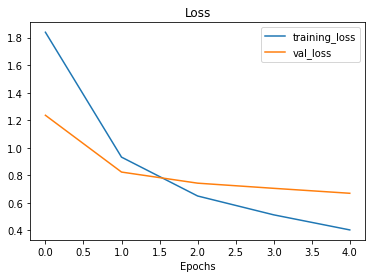

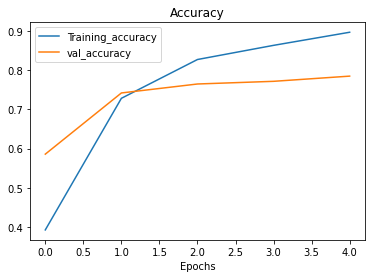

In [31]:
plot_loss_curves(resnet_history)

### Creating and Testing EfficientNetB0 TensorFlow Hub Feature Extraction Model

In [36]:
# Create efficientnet model
efficientnet_model = create_model(efficientnet_url,
                           num_classes=train_data_10_percent.num_classes)

In [37]:
# Compile our resnet model
efficientnet_model.compile(loss='categorical_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['accuracy'])

In [38]:
# model summary
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [39]:
# Fit our ResNet model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=len(test_data),
                                 callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                       experiment_name='efficientnetb0')])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20220630-002610
Epoch 1/5
24/24 [==============================] - 20s 512ms/step - loss: 1.8372 - accuracy: 0.4187 - val_loss: 1.3267 - val_accuracy: 0.7000
Epoch 2/5
24/24 [==============================] - 8s 334ms/step - loss: 1.0754 - accuracy: 0.7573 - val_loss: 0.8827 - val_accuracy: 0.8116
Epoch 3/5
24/24 [==============================] - 8s 333ms/step - loss: 0.7584 - accuracy: 0.8373 - val_loss: 0.7067 - val_accuracy: 0.8372
Epoch 4/5
24/24 [==============================] - 8s 335ms/step - loss: 0.6093 - accuracy: 0.8667 - val_loss: 0.6153 - val_accuracy: 0.8488
Epoch 5/5
24/24 [==============================] - 8s 333ms/step - loss: 0.5136 - accuracy: 0.8920 - val_loss: 0.5617 - val_accuracy: 0.8576


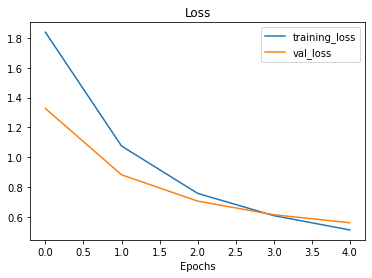

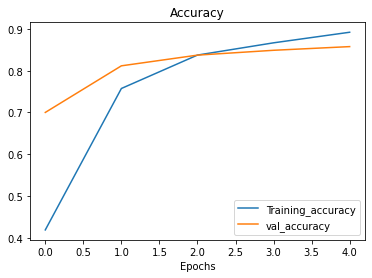

In [40]:
plot_loss_curves(efficientnet_history)

In [44]:
# how many layers does our efficientnetb0 feature extractor have ?
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes waht so ever
* **"Feature extaction" transfer learning** - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and aadjust the output layer for your own problem (e.g. 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

In [49]:
# Comparing our models result using TensorBoard
logdir = "./tensorflow_hub/"
!tensorboard dev upload --logdir {logdir}\
    --name "EfficientNetB0 vs. ResNet50V2" \
    --description "Comparing two diffrent TF HUB Feature Extraction model architectures"\
    --one_shot

^C
